In [111]:
%matplotlib inline

In [112]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle
from librosa_ours import librosa as lib_ours
import glob
import re
import sys
import os
import mido
from mido import MidiFile

import librosa.display
import pretty_midi
import csv

### Load strips

All pkl data lies in this directory

In [113]:
pkl_dir = 'score_data_mazurka/pkl_data'

In [114]:
def sort_nicely(l):
    d = {}
    for elem in l:
        m = re.search('\S+-(\d+)\.pkl', elem)
        if m:
            idx = int(m.group(1))
            d[idx] = elem
        else:
            print('Failed regular expression matching: %s') % (elem)
            sys.exit(1)
    sorted_filenames = [d[key] for key in sorted(d.keys())]
    return sorted_filenames

In [115]:
def loadStripData(basename):
    pkl_files = sort_nicely(glob.glob(pkl_dir + '/' + basename + '-*.pkl'))
    print(pkl_files)
    strips = []
    for pkl_file in pkl_files:
        with open(pkl_file, 'rb') as f:
            d = pickle.load(f)
            strips.extend(d['strips'])
    return strips

In [116]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

In [117]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

In [118]:
scoreFile = 'op30no2_v1'

In [119]:
strips = loadStripData(scoreFile)

['score_data_mazurka/pkl_data/op30no2_v1-0.pkl', 'score_data_mazurka/pkl_data/op30no2_v1-1.pkl']


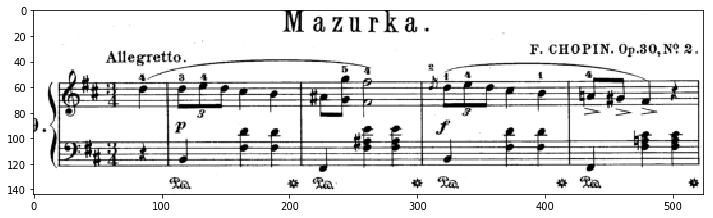

In [120]:
showImage(strips[0])

### Sheet music strip analysis

In [121]:
def locateStaffLines(s, delta = 3):
    medvals = np.median(s, axis=1)
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10])
    return np.array(idxs_lines)

In [122]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s') % hand
        sys.exit(1)
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [123]:
def estimatePixelRow(midinum, m, b):
    return np.int(np.round(midinum * m + b))

Estimate the location of C4 in the sheet music

In [124]:
s = strips[0]
lines = locateStaffLines(s)
breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

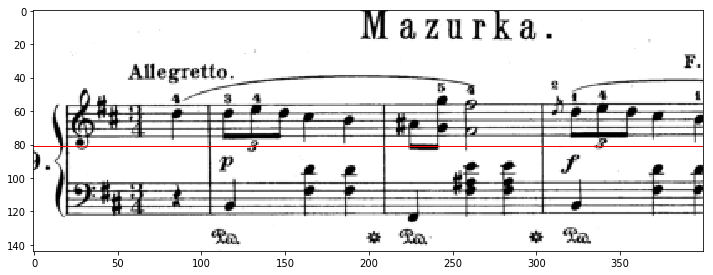

In [125]:
showImage(s[:,0:400])
plt.axhline(y = estC4, color='r', linewidth=1)
plt.show()

To prevent the system from matching notes to barlines, we suppress vertical lines

In [126]:
def suppressVerticalLines(s):
    rowStart = int(s.shape[0]*.25)
    rowEnd = int(s.shape[0]*.75) + 1
    medians = np.median(s[rowStart:rowEnd,:], axis=0)
    suppressed = np.clip(s - medians, 0, 1)
    return suppressed

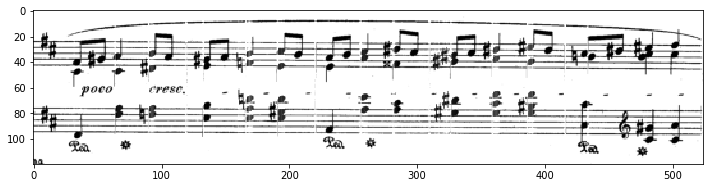

In [127]:
sup = suppressVerticalLines(strips[5])
showImage(sup)

### Synthesize sheet music from midi

In [128]:
def getMidiNoteEvents(midifile, fs = 100):
    mid = MidiFile(midifile)
    noteEvents = []
    tempo = 500000 # default microseconds per beat
    curTimeSec = 0.0
    assert(len(mid.tracks) == 1)
    for msg in mid.tracks[0]:
        curTimeSec += mido.tick2second(msg.time, mid.ticks_per_beat, tempo)
        if msg.type == 'set_tempo':
            tempo = msg.tempo
        if msg.type == 'note_on':
            colIdx = np.int(np.round(curTimeSec * fs))
            noteEvents.append((colIdx, msg.note))
        if msg.type == 'text' and '!!!END:' in msg.text: # ignore command messages that add time at end
            break            
    return noteEvents

In [129]:
def synthesizeSheetMusic(noteEvents, strip, zeroPad = 50):
    
    # analyze the strip
    lines = locateStaffLines(strip)
    breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
    upper = strip[0:breakpt,:]
    lower = strip[breakpt:,:]
    m1, b1 = estimateMidiNum2PixelRowMapping(upper, lines[0:5], 'right')
    m2, b2 = estimateMidiNum2PixelRowMapping(lower, lines[5:10] - breakpt, 'left')
    
    # synthesis
    impulses1 = generateNoteImpulses(noteEvents, upper, m1, b1)
    impulses2 = generateNoteImpulses(noteEvents, lower, m2, b2)
    impulses = mergeNoteImpulses(impulses1, impulses2, noteEvents)
    timeAdjusted, timeMapping = adjustMidiTiming(impulses)
    zeroPadded = zeroPadColumns(timeAdjusted, zeroPad, zeroPad)
    filt2d = get2DFilter(np.mean([np.abs(m1),np.abs(m2)]))
    blurred = convolve2d(zeroPadded, filt2d, 'same')
    stavesTemplate = np.matlib.repmat(np.median(strip, axis=1).reshape(-1,1), 1, blurred.shape[1])
    withLines = np.clip(blurred + stavesTemplate, 0, 1)
    return withLines, timeMapping

In [130]:
def generateNoteImpulses(noteEvents, strip, m, b):
    synthLen = noteEvents[-1][0] + 1
    impulses = np.zeros((strip.shape[0], synthLen))
    for (timeIdx, midinum) in noteEvents:
        row = estimatePixelRow(midinum, m, b)
        if row >= 0 and row < strip.shape[0]:
            impulses[row, timeIdx] = 1
    return impulses

In [131]:
def mergeNoteImpulses(impulses1, impulses2, noteEvents):
    # This function double checks that whenever a note event occurs, at least one note shows up in the 
    # synthesized score (adding a redundant note if necessary).  This avoids the rare situation where a
    # note event occurs but falls outside of both strips, which leads to midi synthesized scores having
    # different lengths due to shortening of long pauses.
    merged = np.vstack((impulses1, impulses2))
    csum = np.sum(merged, axis=0)
    for (timeIdx, midiNote) in noteEvents:
        if csum[timeIdx] == 0:
            merged[0, timeIdx] = 1 # add redundant note
    return merged

In [132]:
def adjustMidiTiming(noteImpulses, maxPauseLen = 50):
    
    # identify long pauses where no onsets occur
    csums = np.sum(noteImpulses, axis=0)   
    dataToInsert = [] # either the index of the column to insert, or -1 for a column of zeros
    isPause = False
    markerStart = 0
    for i in range(len(csums)):
        if isPause:
            if csums[i] != 0 or i == len(csums) - 1: # in a pause, notes occur
                pauseLen = i - markerStart
                if pauseLen > maxPauseLen:
                    dataToInsert.extend([-1] * maxPauseLen)
                else:
                    dataToInsert.extend([-1] * pauseLen)
                dataToInsert.append(i)
                isPause = False
            else: # in a pause, no notes occur
                pass
        else:
            if csums[i] != 0: # not a pause, notes occur
                dataToInsert.append(i)
            else: # not a pause, no notes occur
                isPause = True
                markerStart = i
    
    # reconstruct onset data
    adjusted = np.zeros((noteImpulses.shape[0],len(dataToInsert)))
    for i, col in enumerate(dataToInsert):
        if col == -1:
            pass # leave as zeros
        else:
            adjusted[:,i] = noteImpulses[:,col]
    return adjusted, dataToInsert

In [133]:
def get2DFilter(m):
    filt_sz = np.int(np.round(np.abs(m) * 4))
    filt2d = getBlurFilter(filt_sz, 'block')
    return filt2d

In [134]:
def getBlurFilter(sz, filterType):
    if filterType == 'hamming':
        filt = np.matmul(np.hamming(sz).reshape((sz,1)), np.hamming(sz).reshape(1,sz))
    elif filterType == 'circle':
        filt = np.zeros((sz,sz))
        center = sz/2
        for i in range(sz):
            for j in range(sz):
                if np.sqrt((i-center)*(i-center)+(j-center)*(j-center)) <= center - .01:
                    filt[i,j] = 1
    elif filterType == 'block':
        filt = np.ones((sz,np.int(1.5*sz)))
    else:
        print('Unrecognized filter type: %s' % filterType)
        sys.exit(1)
    return filt

In [135]:
def zeroPadColumns(X, nBefore, nAfter):
    h = X.shape[0]
    Y = np.hstack((np.zeros((h,nBefore)), X, np.zeros((h,nAfter))))
    return Y

In [136]:
#midiFile = 'midi/op68no3/pid1263b-19-avgtapsd0.mid'
#midiFile = 'midi/op63no3/pid9058b-12-avgtapsd0.mid'
midiFile = 'midi/op30no2/pid9048-19-avgtapsd0.mid'
noteEvents = getMidiNoteEvents(midiFile)
midiSynth, _ = synthesizeSheetMusic(noteEvents, s)

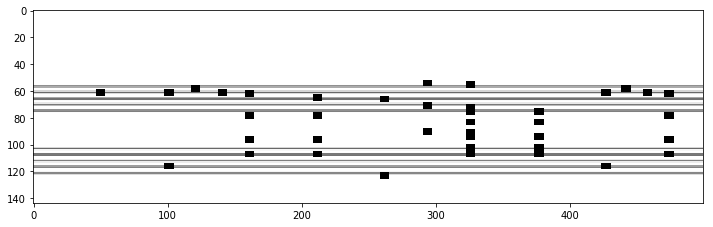

In [137]:
showImage(midiSynth[:,0:500])

### Align sequence of strips

In [138]:
def alignStripSequence(strips, midiFile, zeroPad = 50):
    
    # find optimal fs
    fs = 100.0
    noteEvents = getMidiNoteEvents(midiFile, fs)
    striplen = np.sum([s.shape[1] for s in strips])
    fs = np.int(fs * striplen / noteEvents[-1][0]) # adjust to get equal lengths
    noteEvents = getMidiNoteEvents(midiFile, fs)
    
    # fill in cost matrix block by block
    Cblocks = []
    midiSynths = []
    for i in range(len(strips)):
        s = suppressVerticalLines(strips[i])
        midiSynth, timeMapping = synthesizeSheetMusic(noteEvents, s, zeroPad)
        costBlock = -1.0 * np.matmul(s.T, midiSynth)
        Cblocks.append(costBlock)
        midiSynths.append(midiSynth)
    C = np.vstack(Cblocks)
        
    # DTW
    steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([2,3,3])
    D, wp = librosa.core.dtw(C=C, step_sizes_sigma=steps, weights_mul=weights)
    
    return wp[::-1,:], midiSynths, timeMapping, fs

In [139]:
def getCostMatrixForHierarchicalDTW(strips, midiFile, zeroPad = 50, normalize=False):
    
    # get combination of last column of each subsequence DTW
    # in each location have it be a tuple with (cost, start height of path)
    
    # find optimal fs
    fs = 100.0
    noteEvents = getMidiNoteEvents(midiFile, fs)
    striplen = np.sum([s.shape[1] for s in strips])
    fs = np.int(fs * striplen / noteEvents[-1][0]) # adjust to get equal lengths
    noteEvents = getMidiNoteEvents(midiFile, fs)
    
    # DTW parameters
    steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([1,1,2])
    
    bestWarpingPaths = []
    warpingPaths = []
    costMatrices = []
    
    # fill in cost matrix block by block
    endRows = []
    midiSynths = []
    #for i in range(1):
    for i in range(len(strips)):
        warpingPathsForStrip = []
        
        print("Processing strip ", i)
        # run subsequence dtw between the current strip and the entire midi bootleg
        # projected into that strip's frame
        s = suppressVerticalLines(strips[i])
        midiSynth, timeMapping = synthesizeSheetMusic(noteEvents, s, zeroPad)
        costBlock = -1.0 * np.matmul(s.T, midiSynth)
        
        midiSynths.append(midiSynth)
        
        # normalize the cost block based on the total number of black pixels in the comparison
        summedMidiSynth = np.sum(midiSynth, axis=0)
        summedStrip = np.sum(s, axis=0)
        
        repeatMidiSum = np.tile(summedMidiSynth, [summedStrip.shape[0], 1])
        repeatStripSum = np.tile(summedStrip, [summedMidiSynth.shape[0], 1])
        
        normalizingMatrix = repeatMidiSum + repeatStripSum.T
        if normalize:
            costBlock = costBlock / normalizingMatrix
        
        accumCost, warpingPath, accumCostSteps = lib_ours.core.dtw(C=costBlock, step_sizes_sigma = steps, weights_mul = weights, subseq =  True, return_steps = True)
        costMatrices.append(accumCost)
        bestWarpingPaths.append(warpingPath)
        
        # find the costs corresponding end of the strip (cost for particular alignments of that subsequence)
        costsAtEndOfStrip = accumCost[-1, :]
        costStartHeightTuples = []
        # for each cost at the end of the strip find the path that would lead to that cost
        # and store the start location
        #for costIndex in range(350,1200):
        for costIndex in range(len(costsAtEndOfStrip)):    
            curBacktrace = lib_ours.sequence.__dtw_backtracking(accumCostSteps[:, :(costIndex + 1)], steps)
            warpingPathsForStrip.append(curBacktrace)
            startHeight = curBacktrace[-1][1]
            costStartHeightTuples.append((costsAtEndOfStrip[costIndex], startHeight))
            #plt.plot([cur[0] for cur in curBacktrace], [cur[1] for cur in curBacktrace])
        
        warpingPaths.append(warpingPathsForStrip)
        endRows.append(costStartHeightTuples)
    
    # turn them into an np array, and transpose then return
    # we transpose so that the array has dim of: (height of synthesized MIDI, number of strips, 2)
    npEndRows = np.array(endRows, dtype=(float, int))
    return np.transpose(npEndRows, (1,0,2)), costMatrices, bestWarpingPaths, warpingPaths, midiSynths # only transpose the first 2 dimensions
    

In [140]:

# DTW parameters
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
    

costBlock = np.zeros((7,4))
costBlock[(0,0)] = -100
costBlock[(1,0)] = -100
costBlock[(1,1)] = -100
costBlock[(2,2)] = -100
costBlock[(3,3)] = -100
costBlock[(3,0)] = -200
costBlock[(4,1)] = -200
costBlock[(5,2)] = -200
costBlock[(6,3)] = -200

print("costBlock")
print(costBlock.T)

costBlock = costBlock.T
        
accumCost, warpingPath, accumCostSteps = lib_ours.core.dtw(C=costBlock, step_sizes_sigma = steps, weights_mul = weights, subseq =  True, return_steps = True)
print("accumCost")
print(accumCost)
print("warpingPath")
print(warpingPath)
        
        # find the costs corresponding end of the strip (cost for particular alignments of that subsequence)
costsAtEndOfStrip = accumCost[-1, :]
costStartHeightTuples = []
        # for each cost at the end of the strip find the path that would lead to that cost
        # and store the start location
for costIndex in range(len(costsAtEndOfStrip)):
    startHeight = lib_ours.sequence.__dtw_backtracking(accumCostSteps[:, :(costIndex + 1)], steps)[-1][1]
    costStartHeightTuples.append((costsAtEndOfStrip[costIndex], startHeight))
print("costStartHeightTuples: ")
print(costStartHeightTuples)
    

costBlock
[[-100. -100.    0. -200.    0.    0.    0.]
 [   0. -100.    0.    0. -200.    0.    0.]
 [   0.    0. -100.    0.    0. -200.    0.]
 [   0.    0.    0. -100.    0.    0. -200.]]
accumCost
[[ -100.  -100.     0.  -200.     0.     0.     0.]
 [   inf  -300.  -100.  -100.  -600.  -200.     0.]
 [   inf  -100.  -500.  -300.  -200. -1000.  -600.]
 [   inf    inf  -300.  -700.  -500.  -600. -1400.]]
warpingPath
[[3 6]
 [2 5]
 [1 4]
 [0 3]]
costStartHeightTuples: 
[(inf, -2), (inf, -1), (-300.0, 0), (-700.0, 0), (-500.0, 0), (-600.0, 3), (-1400.0, 3)]


In [141]:
def visualizeAlignedSequences(strips, midiSynths, wp, scoreFile = None, midiFile = None):
    
    # generate panorama of sheet music strips 
    maxH = np.max([s.shape[0] for s in strips])
    pan1 = np.zeros((maxH, wp.shape[0]))
    cumStripLens = np.cumsum([0] + [s.shape[1] for s in strips])
    col2strip = [i for i, s in enumerate(strips) for j in range(s.shape[1])] # column index -> strip index
    for i in range(wp.shape[0]):
        globalIdx = wp[i,0]
        stripIdx = col2strip[globalIdx]
        h = strips[stripIdx].shape[0]
        localIdx = globalIdx - cumStripLens[stripIdx]
        pan1[0:h,i] = strips[stripIdx][:, localIdx]
        
    # generate panorama for midi synthesis
    pan2 = np.zeros((maxH, wp.shape[0]))
    for i in range(wp.shape[0]):
        sheetColIdx = wp[i,0]
        midiColIdx = wp[i,1]
        stripIdx = col2strip[sheetColIdx]
        h = strips[stripIdx].shape[0]
        pan2[0:h, i] = midiSynths[stripIdx][:,midiColIdx]

    stacked = np.vstack((pan1, pan2))
    
    # overlay score beat annotations
    if scoreFile:
        with open('gt.pkl', 'rb') as f: # e.g. op68no3_v3
            d = pickle.load(f) 
        scoreRefBeats = d[scoreFile]
        xcoords = np.interp(scoreRefBeats, wp[:,0], range(wp.shape[0]))
        for x in xcoords:
            if not np.isnan(x):
                stacked[0:maxH,np.int(np.round(x))] = .5
    
    # overlay midi beat annotations
    if midiFile:
        with open('gt.pkl', 'rb') as f: # e.g. midi/op68no3/pid1263b-19-avgtapsd0.mid
            d = pickle.load(f) 
        basename = os.path.splitext(os.path.basename(midiFile))[0]
        midiID = '%s--%s' % (scoreFile, basename)
        midiRefBeats = d[midiID]
        xcoords = np.interp(midiRefBeats, wp[:,1], range(wp.shape[0]))
        for x in xcoords:
            if not np.isnan(x):
                stacked[maxH:,np.int(np.round(x))] = .5
    
    return stacked

In [142]:
originalWP, midiSynths, _, _ = alignStripSequence(strips, midiFile)
endCost, costMatrices, bestWarpingPaths, warpingPaths, midiSynths = getCostMatrixForHierarchicalDTW(strips, midiFile, normalize=False)
#endCostNormalized, costMatricesNormalized, bestWarpingPathsNormalized, warpingPathsNormalized, midiSynthsNormalized = getCostMatrixForHierarchicalDTW(strips, midiFile, normalize=True)
# write it to a text file
np.savetxt('mazurkaEndCostCosts.csv', endCost[:,:,0], delimiter=',')
np.savetxt('mazurkaEndCostStartLocations.csv', endCost[:,:,1], delimiter=',')
np.savetxt('mazurkaWP.csv', originalWP, delimiter=',')

Processing strip  0
Processing strip  1
Processing strip  2
Processing strip  3
Processing strip  4
Processing strip  5
Processing strip  6
Processing strip  7
Processing strip  8
Processing strip  9
Processing strip  10
Processing strip  11


In [143]:
endCostCosts = endCost[:, :, 0]
print(endCostCosts.shape)
# endCostCosts = np.zeros((3,3))
print(endCostCosts)
endCostCosts[endCostCosts==np.inf] = 0

# DTW
steps = np.array([1,0,0,1]).reshape((-1,2))
print(steps)
weights = np.array([0, 1])
D, wp = librosa.core.dtw(C=endCostCosts, step_sizes_sigma=steps, subseq=False, weights_mul=weights)


print(wp)

lastPoint = wp[0]
ideaOnePath = []
for point in wp:
    if lastPoint[1] != point[1]:
        ideaOnePath.append(lastPoint)
    lastPoint = point
    
    if point[1] == 0:
        print(point[0])

print(ideaOnePath)

(6267, 12)
[[           inf            inf            inf ...,            inf
             inf            inf]
 [           inf            inf            inf ...,            inf
             inf            inf]
 [           inf            inf            inf ...,            inf
             inf            inf]
 ..., 
 [-3590.71064209 -2949.51223778 -3354.80141741 ..., -3861.81405598
  -3800.9459712  -3752.1434809 ]
 [-3590.68163664 -2949.51223778 -3354.80141741 ..., -3861.81405598
  -3800.9459712  -3752.1434809 ]
 [-3590.68163664 -2949.51223778 -3348.14719695 ..., -3861.81405598
  -3800.9459712  -3752.1434809 ]]
[[1 0]
 [0 1]]
[[6266   11]
 [6265   11]
 [6264   11]
 ..., 
 [   2    0]
 [   1    0]
 [   0    0]]
1248
1247
1246
1245
1244
1243
1242
1241
1240
1239
1238
1237
1236
1235
1234
1233
1232
1231
1230
1229
1228
1227
1226
1225
1224
1223
1222
1221
1220
1219
1218
1217
1216
1215
1214
1213
1212
1211
1210
1209
1208
1207
1206
1205
1204
1203
1202
1201
1200
1199
1198
1197
1196
1195
1194
1193


(12, 2)


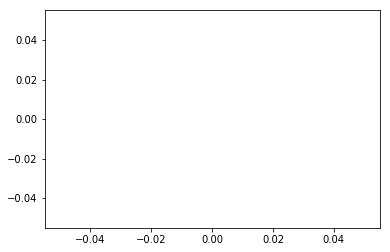

In [144]:
curEndCost = endCost[0]
print(curEndCost.shape)
plt.plot(range(len(endCost[15000:17500, 0, 0])), endCost[15000:17500, 0, 0])

[]

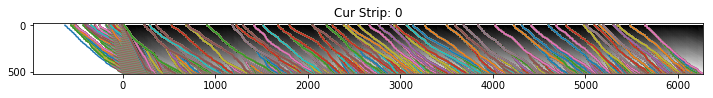

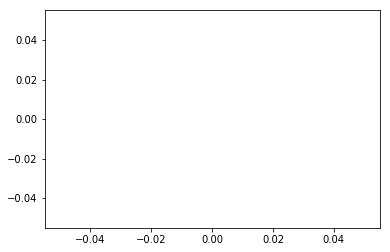

In [145]:
showImage(costMatrices[0])
plt.title("Cur Strip: " + str(0))
#print(warpingPaths[0][0])
#print(len(warpingPaths))
for backtraceIndex in range(len(warpingPaths[0])):
    curPath = np.array(warpingPaths[0][backtraceIndex])
    plt.plot(curPath[:,1], curPath[:, 0])

    
plt.figure()
plt.plot()

(12, 2)


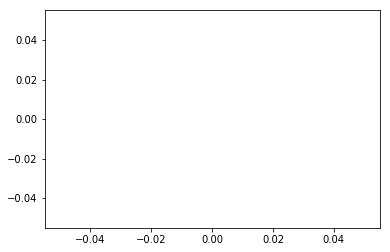

In [ ]:
curEndCost = endCost[0]
print(curEndCost.shape)
plt.plot(range(len(endCost[15000:17500, 0, 0])), endCost[15000:17500, 0, 0])


//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


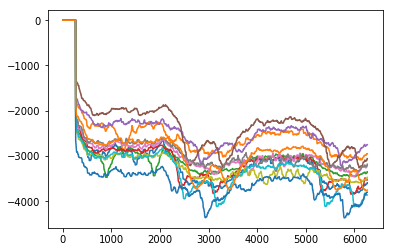

<Figure size 432x288 with 0 Axes>

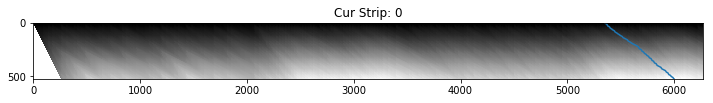

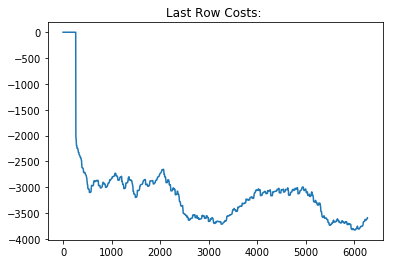

<Figure size 432x288 with 0 Axes>

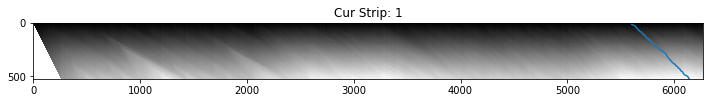

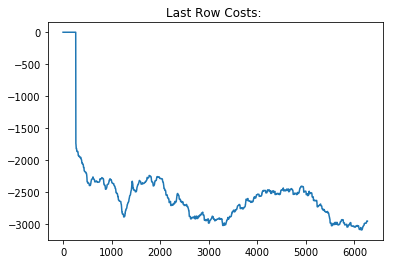

<Figure size 432x288 with 0 Axes>

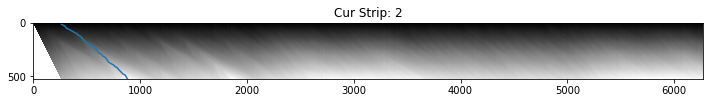

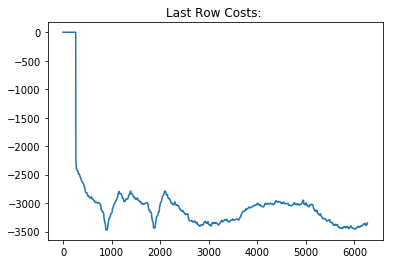

<Figure size 432x288 with 0 Axes>

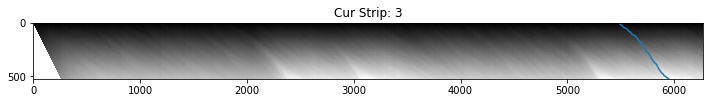

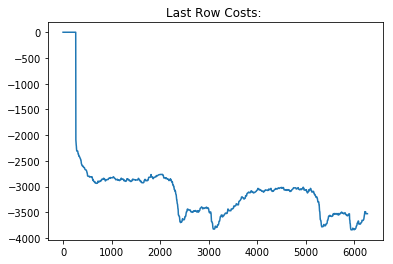

<Figure size 432x288 with 0 Axes>

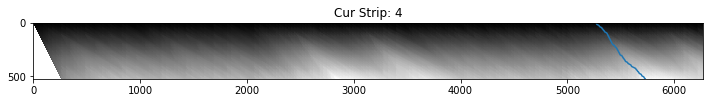

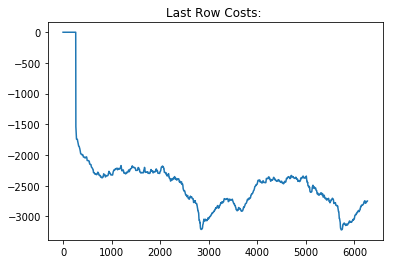

<Figure size 432x288 with 0 Axes>

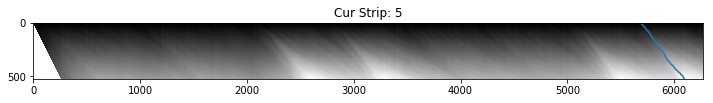

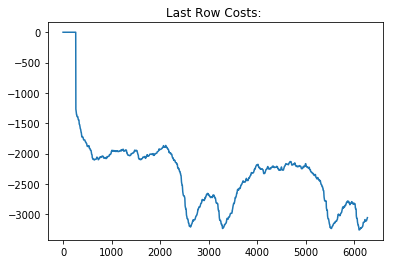

<Figure size 432x288 with 0 Axes>

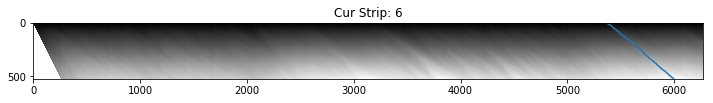

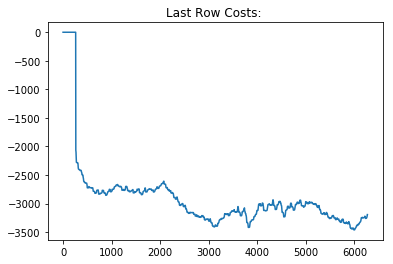

<Figure size 432x288 with 0 Axes>

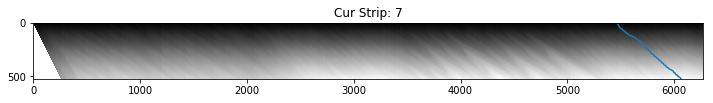

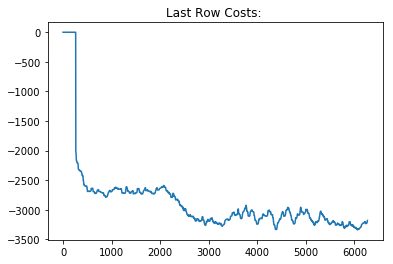

<Figure size 432x288 with 0 Axes>

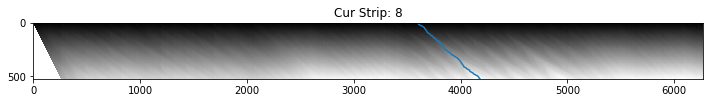

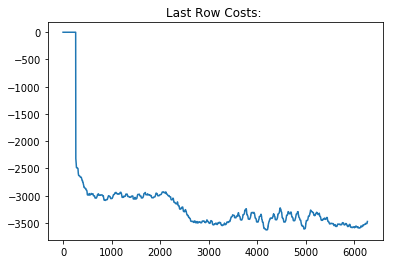

<Figure size 432x288 with 0 Axes>

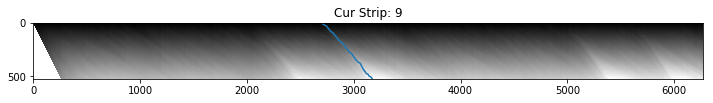

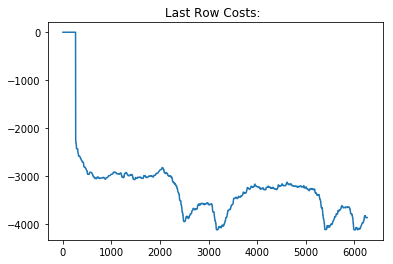

<Figure size 432x288 with 0 Axes>

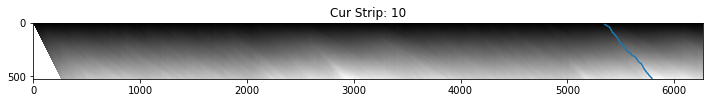

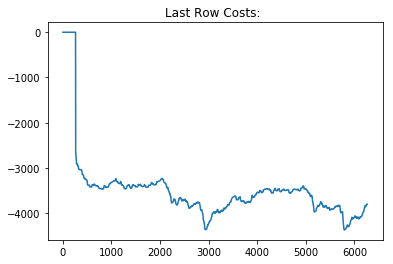

<Figure size 432x288 with 0 Axes>

In [ ]:
# plotting un-normalized
for stripIndex in range(len(costMatrices)):
    
    plt.figure(0)
    plt.plot(range(endCost.shape[0]), endCost[:, stripIndex, 0], label=str(stripIndex))
    
    plt.figure()
    curPath = np.array(bestWarpingPaths[stripIndex])
    showImage(costMatrices[stripIndex])
    plt.plot(curPath[:,1], curPath[:, 0])
    plt.title("Cur Strip: " + str(stripIndex))
    
    plt.figure()
    plt.title("Last Row Costs: ")
    plt.plot(range(endCost.shape[0]), endCost[:, stripIndex, 0])


In [ ]:
# plotting normalized
for stripIndex in range(len(costMatricesNormalized)):
    
    plt.figure(0)
    plt.plot(range(endCostNormalized.shape[0]), endCostNormalized[:, stripIndex, 0], label=str(stripIndex))
    
    plt.figure()
    curPath = np.array(bestWarpingPathsNormalized[stripIndex])
    showImage(costMatricesNormalized[stripIndex])
    plt.plot(curPath[:,1], curPath[:, 0])
    plt.title("Cur Strip: " + str(stripIndex))
    
    plt.figure()
    plt.title("Last Row Costs: ")
    plt.plot(range(endCostNormalized.shape[0]), endCostNormalized[:, stripIndex, 0])



In [ ]:
stacked = visualizeAlignedSequences(strips, midiSynths, originalWP)
#stacked = visualizeAlignedSequences(strips, midiSynths, wp, scoreFile, midiFile) # with gt (need to have run 03_Evaluate.ipynb to create ground truth data)

In [ ]:
start = 0
end = start+500
showImage(stacked[:,start:end])
#plt.axis('off')
#plt.savefig('figs/exampleCorrect.png', dpi=300, bbox_inches = 'tight') # op68no3_v2, pid1263b-19-avgtapsd0.mid
#plt.savefig('figs/exampleWrong.png', dpi=300, bbox_inches = 'tight') # op30no2_v4, pid9073-21-avgtapsd0.mid

In [ ]:
showImage(stacked)

In [ ]:
def visualizeAlignment(stacked, width = 1000):
    chunks = int(np.ceil(stacked.shape[1] / width))
    for i in range(chunks):
        startCol = i*width
        endCol = min((i+1)*width, stacked.shape[1])
        showImage(stacked[:,startCol:endCol], (10,6))

In [ ]:
visualizeAlignment(stacked, 600)

### Align all midi-sheet pairs

In [ ]:
pieces = ['op30no2_v1']
hyp_dir = 'hyp_align'
# os.mkdir(hyp_dir)
zeroPad = 50

for piece in pieces:  # for every pair of matching scores
    scores = [os.path.basename(elem) for elem in sorted(glob.glob('score_data_mazurka/prepped_png/%s' % piece))]
    print(scores)
    midifiles = [m for m in sorted(glob.glob('score_data_mazurka/midi/%s/*.mid' % piece))]
    print(midifiles)
    for score in scores:
        strips = loadStripData(score)
        striplens = [s.shape[1] for s in strips]
        for i, midifile in enumerate(midifiles):
            print(1)
            # warping path
            wp, midiSynths, timeMapping, fs = alignStripSequence(strips, midifile, zeroPad)
            print(2)
            midiID = os.path.splitext(os.path.basename(midifile))[0]
            print(3)
            outfile = '%s/%s--%s.pkl' % (hyp_dir, score, midiID)
            print(4)
            with open(outfile,'wb') as f:
                pickle.dump({'wp':wp,'striplens':striplens,'fs':fs,'zeroPad':zeroPad,'timeMapping':timeMapping}, f)
            print('Processed %d of %d, %s' % (i+1, len(midifiles), score))

### Load predictions

In [ ]:
def loadHypothesisData(hyp_file):
    with open(hyp_file, 'rb') as f:
        dhyp = pickle.load(f)
    fs = dhyp['fs']
    zeroPad = dhyp['zeroPad']
    timeMapping = dhyp['timeMapping']
    striplens = dhyp['striplens']
    wp = dhyp['wp']

    sheet_preds = wp[:,0]
    midi_preds = wp[:,1]
    
    return sheet_preds, midi_preds

In [ ]:
hyp_file = 'hyp_align/op30no2_v1--pid9048-19-avgtapsd0.pkl'

sheet_preds, midi_preds = loadHypothesisData(hyp_file)

print(sheet_preds)
print(midi_preds)

In [ ]:
### visualize the mapping
def visualizeDTWResults(predictedXs, predictedYs, synthesizedSamplingFreq, hopLength): #, groundTruthXs, groundTruthYs):
    # a plot of the warping path on top of a color map of the accumulated cost matrix
    plt.subplot(2, 1, 1)
#     librosa.display.specshow(accumCost, x_axis='time', y_axis='time', sr = synthesizedSamplingFreq, hop_length = hopLength)
    plt.title('MIDI, Performance DTW')
    plt.plot(predictedXs, predictedYs, label = 'Optimal Path', color='y')
#     plt.plot(groundTruthXs, groundTruthYs, label = 'Ground Truth', color='w')
    plt.legend()

    # a plot of the cost function at each point on the path (how well each part of the alignment matches)
#     plt.subplot(2, 1, 2)
#     plt.plot(accumCost[-1,:] / predictedXs.shape[0])
#     plt.xlim([0, accumCost.shape[1]])
#     plt.ylim([0, 2])
#     plt.title('Matching cost function')
#     plt.tight_layout()

In [ ]:
visualizeDTWResults(sheet_preds, midi_preds, fs, 1)

### Find pixels in sheet music that correlate to MIDI downbeats (from ground truth)

In [ ]:
def getMidiDownbeatsFromPrettyMidi(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    timeStamps = midi_data.get_downbeats()
    return timeStamps[1:] # we throw one away since it counts measure 0

In [ ]:
def getMidiDownbeatsFromFile(annotMidiFile):
    with open(annotMidiFile, 'r') as f:
        reader = csv.reader(f)
        timeStamps = list(reader)
    return np.array([float(i) for i in timeStamps[0]]) # there's only one line in csv, and we ony want line 1

In [ ]:
def getPixelsCorrespondingToMidiTimes(timeStamps, timeMapping):
    frames = (timeStamps - timeStamps[0]) * fs
    mapped_frms = [i for i, elem in enumerate(timeMapping) if elem != -1]
    orig_frms = [elem for elem in timeMapping if elem != -1]
    mapped_interp = np.interp(frames, orig_frms, mapped_frms)
    padded = mapped_interp + zeroPad

    midi_ref_beats = padded
    return midi_ref_beats
    
    #hypPixels = np.interp(midi_ref_beats, midi_preds, sheet_preds)
    return hypPixels

In [ ]:
annotMidiFile = "annot_audio/op30no2/midi_downbeats.csv" # "midi/op30no2/pid9048-19-avgtapsd0.mid"
midiDownbeats = getMidiDownbeatsFromFile(annotMidiFile)
print(midiDownbeats)
midiDownbeatsToPixels = getPixelsCorrespondingToMidiTimes(midiDownbeats)
print(len(midiDownbeatsToPixels))
print(midiDownbeatsToPixels)

### Map from measures in sheet music to corresponding line number

In [ ]:
def measuresToLineNumbers(annot_sheet_file):
    # Open sheet music annotation file and save data
    # NOTE: We assume that the sheet music file contains an extra data point containing the
    # value where the next measure would be if there was an additional line in the piece
    with open(annot_sheet_file, 'r') as f:
        reader = csv.reader(f)
        lineMeasureNumbers = list(reader)

    # There is only one line in the csv file
    lineMeasureNumbers = lineMeasureNumbers[0]

    # Create a mapping from each measure to the line it corresponds to
    downbeatsToLineNumbers = []
    previousMeasure = 1
    for line, measure in enumerate(lineMeasureNumbers[1:], 1):
        temp = [line] * (int(measure)-previousMeasure)
        downbeatsToLineNumbers += temp
        previousMeasure = int(measure)
    
    return downbeatsToLineNumbers

In [ ]:
annot_sheet_file = 'annot_sheet/op30no2_strips.csv'
downbeatsToLine = measuresToLineNumbers(annot_sheet_file)

print(len(downbeatsToLine))
print(downbeatsToLine)

### Map from pixel number to a line in sheet music

In [ ]:
def pixelToLine(pixelNum):
    lineWidth = strips[0].shape[1]
    return (int(pixelNum/lineWidth)+1)

In [ ]:
def pixelsArrayToLines(hypPixels):
    hypPixelsLines = []
    for pixel in hypPixels:
        hypPixelsLines += [pixelToLine(pixel)]
    return hypPixelsLines

In [ ]:
midiDownbeatsToLines = pixelsArrayToLines(midiDownbeatsToPixels)
print(len(midiDownbeatsToLines))
print(midiDownbeatsToLines)

### Map from an array of midi times to sheet music line numbers

In [ ]:
def midiTimeToSheetLine(timeStamps):
    hypPixels = getPixelsCorrespondingToMidiTimes(timeStamps)
    return pixelsArrayToLines(hypPixels)

In [ ]:
# takes in a list of midi times corresponding to downbeats in audio
def measureAccuracy(midiTimeStamps, annotSheetLines):
    sheetLinesGroundTruth = measuresToLineNumbers(annotSheetLines)
    audioDownbeatsToLines = midiTimeToSheetLine(midiTimeStamps)
    
    if len(sheetLinesGroundTruth) != len(audioDownbeatsToLines):
        return("the arrays to compare are not the same length! panic!")
    countIncorrect = 0
    for i in range(len(sheetLinesGroundTruth)):
        if sheetLinesGroundTruth[i] != audioDownbeatsToLines[i]:
            countIncorrect += 1
        print(str(sheetLinesGroundTruth[i]) + ", " + str(audioDownbeatsToLines[i]))
    print("count " + str(countIncorrect))
    print(((1-(float(countIncorrect)/len(sheetLinesGroundTruth)))*100))
    
    print(np.array(sheetLinesGroundTruth) - np.array(audioDownbeatsToLines))

In [ ]:
measureAccuracy(midiDownbeats, annot_sheet_file)

In [ ]:
annotMidiFile = "annot_midi/midiTimeForAudioDownbeats.csv"
audioDownbeatsToMidiTime = np.loadtxt(open(annotMidiFile), delimiter=",")
measureAccuracy(audioDownbeatsToMidiTime, annot_sheet_file)

In [ ]:
print(strips[0].shape[1])
print(strips[1].shape[1])
print(strips[2].shape[1])

In [ ]:
print (downbeatsToLine[127])

In [ ]:
measureAccuracy(midiDownbeats, annot_sheet_file)

In [ ]:
def preprocessHierarchicalDTW(hierarchicalDTWStartLocations, hierarchicalDTWCost):
    height = hierarchicalDTWStartLocations.shape[0]
    width = hierarchicalDTWStartLocations.shape[1]

    endOfNextPath = np.matrix(np.ones((height, width)) * np.inf)

    # Fill in the row index of the end of the first bridge we see
    # where the first bridge we see has a start height greater than the 
    # row we're at
    for col in range(width):
        savedEnd = -1
        savedStart = -1

        for row in range(height):
            # if we have a saved end value, fill that in
            if row < savedStart:
                endOfNextPath[row, col] = savedEnd
            else:
                # look through the hierarchical dtw start locations until we find the best next branch
                done = False
                endIndex = row+1

                while not done and endIndex < height:
                    currentStart = hierarchicalDTWStartLocations[endIndex][col]
                    currentCost = hierarchicalDTWCost[endIndex][col]
                    
                    if currentStart > row:
                        # now, let's actually find the best path which starts at the location we've found
#                         findBestIndex = endIndex
#                         while findBestIndex < height and hierarchicalDTWStartLocations[findBestIndex][col] == currentStart:
#                             # if we find a lower cost, save it!
#                             if hierarchicalDTWCost[findBestIndex][col] < currentCost:
#                                 currentCost = hierarchicalDTWCost[findBestIndex][col]
#                                 endIndex = findBestIndex
#                             findBestIndex += 1

                        endOfNextPath[row, col] = endIndex

                        savedStart = currentStart
                        savedEnd = endIndex

                        done = True
                    endIndex += 1

    return endOfNextPath.astype(int)

In [ ]:
testStarts = np.zeros((7,3))
testCosts = np.zeros((7,3))

testStarts[3,0] = 2
testStarts[4,0] = 2
testStarts[5,0] = 4
testStarts[6,0] = 4

testCosts[3,0] = -100
testCosts[4,0] = -200
testCosts[5,0] = -200
testCosts[6,0] = -100

print(testStarts)
print(testCosts)

preprocessHierarchicalDTW(testStarts, testCosts)

In [ ]:
def hierarchicalDTW(hierarchicalCost, hierarchicalDTWStartLocations, endOfNextPath):
    '''
    We assume we have N strips, and a bootleg MIDI M pixels long

    hierarchicalCost: MxN np array. The last costs in each subsequence DTW accumulated cost matrix concatenated together
    hierarchicalDTWStartLocations: MxN np array. For location m, n it contains the start row of the path that ends at location m, n.
    endOfNextPath: MxN np array. For location m, n it contains the end row of the next path in strip n that starts strictly above location m (as if your previous path ended at m). 

    Returns:
    hierarchicalAccumulatedValue: our accumulated value matrix
    backtrace: an MxN np array of (int, int) tuples. 
    ''' 

    INT_INF = np.array([np.inf]).astype(int)[0] # get the int that np.inf is automatically cast to

    hierarchicalValue = -hierarchicalCost

    height = hierarchicalCost.shape[0]
    width = hierarchicalCost.shape[1]

    WEIGHT_FOR_NEXT_COL = 1.0
    # TEMPORARY make it impossible to jump to other cols
    #WEIGHT_FOR_OTHER_COLS = (1.0 - WEIGHT_FOR_NEXT_COL) / (width - 1)
    WEIGHT_FOR_OTHER_COLS = -np.inf

    # initialize an empty backtrace matrix
    value = np.empty((), dtype=object)
    value[()] = (-1, -1)
    hierarchicalBacktrace = np.full((height, width), value, dtype=object)

    # Initialize all value to be -inf
    accumHierarchicalValue = np.full((height, width), -np.inf)

    # initialize the first column
    # TEMPORARY: only allow us to start at (0,0)
    # accumHierarchicalValue[:, 0] = hierarchicalValue[:, 0]
    # so fill in only the rows which have a 0 start location
    for row in range(height):
        if hierarchicalDTWStartLocations[row, 0] == 0:
#             print("Filling row ", row)
            accumHierarchicalValue[row, 0] = hierarchicalValue[row, 0]

#     print("after first col: ", accumHierarchicalValue[:,0])

    # Consider jumps from every location (except in the last row)
    for row in range(height - 1):
#         print("Percent Done: ", round(100 * (float(row) / height), 1))
        for col in range(width):
            # update all locations that a path ending at this location can jump to.
            # for now we can't jump to our own column, so we remove it
            possibleCols = list(range(width))
            possibleCols.remove(col)
            for jumpCol in possibleCols:
                jumpRow = endOfNextPath[row, jumpCol]
                if (not jumpRow == INT_INF):
                    # weight transitioning to the next strip higher than jumping
                    curWeight = WEIGHT_FOR_NEXT_COL if (jumpCol == col + 1) else WEIGHT_FOR_OTHER_COLS
                    newValue = accumHierarchicalValue[row, col] + curWeight * hierarchicalValue[jumpRow, jumpCol]
                    # if we have found a higher value path to jumpRow, jumpCol then update our accumValue and backtrace
                    if (newValue > accumHierarchicalValue[jumpRow, jumpCol]):
                        # store the new value and the location you jumped from
                        accumHierarchicalValue[jumpRow, jumpCol] = newValue
                        hierarchicalBacktrace[jumpRow, jumpCol] = (row, col)

            # always consider the option to head directly upwards with 0 value added
            # TEMPORARY: for now ignore the option right upwards

            #if (accumHierarchicalValue[row, col] > accumHierarchicalValue[row + 1, col]):
                #accumHierarchicalValue[row + 1, col] = accumHierarchicalValue[row, col]
                #hierarchicalBacktrace[row + 1, col] = (row, col)

    return accumHierarchicalValue, hierarchicalBacktrace

In [ ]:
def hierarchicalBacktrace(accumHierarchicalValue, hierarchicalBacktrace, warpingPaths):
    height = accumHierarchicalValue.shape[0]
    width = accumHierarchicalValue.shape[1]
    stripLengths = [s.shape[1] for s in strips]

    curBest = -np.inf
    curRow = height - 1
    while (curBest == -np.inf):
        curBest = accumHierarchicalValue[curRow, -1]
        curRow = curRow - 1
    curRow = curRow + 1
    curCol = width - 1

    path = []

    print(curCol)
    print(curRow)
#     print("Cur Row: ", curRow, " Cur Col: ", curCol)
    while ((curRow, curCol) != (0, 0) and hierarchicalBacktrace[curRow, curCol] != (-1, -1)):
#         print("Cur Strip: ", curCol, " Cur Row: ", curRow, " Cur Value: ", accumHierarchicalValue[curRow, curCol], " Accum Value: ", accumHierarchicalValue[curRow, :])

        warpingPath = warpingPaths[curCol][curRow]
        # add strip offset to warping paths
        if curCol != 0:
            offset = np.sum(stripLengths[:curCol])
            warpingPath = [(x + offset, y) for (x,y) in warpingPath]
        if curCol == 0:
            print(warpingPath)

        path.extend(warpingPath)
        
        print("strip: ", curCol)

        curRow, curCol = hierarchicalBacktrace[curRow, curCol]
    
    # add last warping path
    lastPath = warpingPaths[0][curRow]
    path.extend(lastPath)
    
    
    # plot warping path
    pathArray = np.array(path)
    plt.plot(pathArray[:,0], pathArray[:,1], label = "Hierarchical DTW")
    
    print(pathArray[0])
    
    # plot original warping path
    originalPath = np.array(originalWP)
    plt.plot(originalPath[:, 0], originalPath[:, 1], label = "Original DTW")
    
    plt.xlabel("Strip")
    plt.ylabel("Midi")
    plt.legend()
    
    print(originalPath[-1])
    
    prevY = -1
    for pathIndex in range(len(path)):
        if path[pathIndex][1] == prevY:
            print(pathIndex)
        prev = path[pathIndex]

#     print("Cur Strip: ", curCol, " Cur Row: ", curRow, " Cur Value: ", accumHierarchicalValue[curRow, curCol], " Accum Value: ", accumHierarchicalValue[curRow, :])



In [ ]:
def hierarchicalBacktraceNotEnd(accumHierarchicalValue, hierarchicalBacktrace, warpingPaths):
    height = accumHierarchicalValue.shape[0]
    width = accumHierarchicalValue.shape[1]
    stripLengths = [s.shape[1] for s in strips]
    curBest = -np.inf
    curRow = height - 1
    curCol = width - 1
    
    path = []
    
    while (curBest == -np.inf):
        curBest = np.amax(accumHierarchicalValue[curRow, :])
        curCol = np.argmax(accumHierarchicalValue[curRow, :])
        curRow = curRow - 1
    curRow = curRow + 1
    #curRow = height - 1
    print("Cur Row: ", curRow, " Cur Col: ", curCol)
    while ((curRow, curCol) != (0, 0) and hierarchicalBacktrace[curRow, curCol] != (-1, -1)):
        print("Cur Strip: ", curCol, " Cur Row: ", curRow, " Cur Value: ", accumHierarchicalValue[curRow, curCol], " Accum Value: ", accumHierarchicalValue[curRow, :])
        
        warpingPath = warpingPaths[curCol][curRow]
        # add strip offset to warping paths
        if curCol != 0:
            offset = np.sum(stripLengths[:curCol])
            warpingPath = [(x + offset, y) for (x,y) in warpingPath]

        path.extend(warpingPath)
        
        curRow, curCol = hierarchicalBacktrace[curRow, curCol]
        
    print("Cur Strip: ", curCol, " Cur Row: ", curRow, " Cur Value: ", accumHierarchicalValue[curRow, curCol], " Accum Value: ", accumHierarchicalValue[curRow, :])
    
    # add last warping path
    lastPath = warpingPaths[curCol][curRow]
    path.extend(lastPath)
    
    
    # plot warping path
    pathArray = np.array(path)
    plt.plot(pathArray[:,0], pathArray[:,1], label = "Hierarchical DTW")
    
    # plot original warping path
    originalPath = np.array(originalWP)
    plt.plot(originalPath[:, 0], originalPath[:, 1], label = "Original DTW")
    
    plt.xlabel("Strip")
    plt.ylabel("Midi")
    plt.legend()

In [ ]:
hierarchicalCost = np.loadtxt(open("mazurkaEndCostCosts.csv"), delimiter=",")
hierarchicalDTWStartLocations = np.loadtxt(open("mazurkaEndCostStartLocations.csv"), delimiter=",")


In [ ]:
endOfNextPath = preprocessHierarchicalDTW(hierarchicalCost, hierarchicalDTWStartLocations)
accumCost, backtrace = hierarchicalDTW(hierarchicalCost, hierarchicalDTWStartLocations, endOfNextPath.astype(int))

### Plot ground truth for each beat

In [ ]:
### for each beat in the sheet music, find the absolute pixel location that it corresponds to
stripPageAndPixelInStrip = np.loadtxt(open("annot_sheet/op30no2_beats.csv"), delimiter=",", skiprows=1, usecols=[3, 4, 5])
scoreName = np.loadtxt(open("annot_sheet/op30no2_beats.csv"), delimiter=",", dtype=np.dtype(str), skiprows=1, usecols=0) 
    
# pull out which rows are using the right version of the sheet music
stripPageAndPixelInStrip = stripPageAndPixelInStrip[scoreName=='op30no2_v1', :]

# in our case (op30no2_v1) the midi annotation only has two beats in measure 64, while the sheet annotation has all 3
# so we'll remove the last item from this list
stripPageAndPixelInStrip = stripPageAndPixelInStrip[:-1, :]

# find the absolute pixel number for each beat
stripLengths = [s.shape[1] for s in strips]
### THIS IGNORES THAT STRIP NUMBER RESETS EACH PAGE, REWRITE SO THAT KEEPS TRACK OF TOTAL NUMBER OF STRIPS YOU'VE SEEN
sheetPixelNumbers = np.zeros(stripPageAndPixelInStrip.shape[0])
lastPage = 0
previousStrip = 0
stripOffset = 0
# deal with the fact that in the annotations the strip number resets to 0 every page
# so we'll keep track of stripOffset, the number of strips in all previous pages
for index, (strip, page, pixelInStrip) in enumerate(stripPageAndPixelInStrip):
    # if you switched to a new page, increase your stripOffset by the number of strips on the previous page
    if (page > lastPage):
        lastPage = page
        stripOffset = stripOffset + previousStrip
    curPixelNumber = np.sum(stripLengths[:int(strip + stripOffset - 1)]) + pixelInStrip
    sheetPixelNumbers[index] = curPixelNumber
    
    # update the previous strip number
    previousStrip = strip
    
    

In [ ]:
### for each beat in the audio, find the absolute pixel location in the bootleg MIDI that it corresponds to
 
## load in the time for each beat from our annotation file
midiTimeForEachBeat = np.loadtxt(open("annot_audio/op30no2/pid9048-19-avgtap-sv.txt"), delimiter="\t", skiprows=5, usecols=[0])

## convert from a time to a pixel location in the bootleg midi
# load the pickle file that contains the time mapping for this midi
with open("hyp_align/op30no2_v1--pid9048-19-avgtapsd0.pkl", 'rb') as f:
    dhyp = pickle.load(f)
timeMapping = dhyp['timeMapping']
midiPixels = getPixelsCorrespondingToMidiTimes(midiTimeForEachBeat, timeMapping)

plt.scatter(sheetPixelNumbers, midiPixels, s=0.5, marker='x', label="ground truth")
plt.legend()
                                 
                                 
                                 
                                 
                                 

In [ ]:
hierarchicalBacktrace(accumCost, backtrace, warpingPaths)
plt.scatter(sheetPixelNumbers, midiPixels, s=2, marker='x', label="ground truth")
plt.legend()

In [ ]:
hierarchicalBacktraceNotEnd(accumCost, backtrace, warpingPaths)


In [ ]:
hierarchicalCostNormalized = np.loadtxt(open("mazurkaEndCostCostsNormalized.csv"), delimiter=",")
hierarchicalDTWStartLocationsNormalized = np.loadtxt(open("mazurkaEndCostStartLocationsNormalized.csv"), delimiter=",")
endOfNextPathNormalized = preprocessHierarchicalDTW(hierarchicalDTWStartLocationsNormalized, hierarchicalCostNormalized)
accumCostNormalized, backtraceNormalized = hierarchicalDTW(hierarchicalCostNormalized, hierarchicalDTWStartLocationsNormalized, endOfNextPathNormalized.astype(int))


In [ ]:
hierarchicalBacktraceNotEnd(accumCostNormalized, backtraceNormalized, warpingPathsNormalized)

In [ ]:
hierarchicalBacktrace(endCostCosts, ideaOnePath, warpingPaths)

In [ ]:
print(backtrace)